## Cell 1: Import Libraries

In [ ]:
import os
import pandas as pd
from ebooklib import epub, ITEM_DOCUMENT
from bs4 import BeautifulSoup
import warnings
import nltk
from nltk.corpus import stopwords
from googletrans import Translator
from langdetect import detect
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')

warnings.filterwarnings('ignore', category=UserWarning, module='ebooklib')
from nltk.stem import WordNetLemmatizer


## Cell 2: Extract Text from EPUB


In [ ]:
def extract_text_from_epub(file_path):
    try:
        book = epub.read_epub(file_path)
        text = []
        for item in book.get_items():
            if item.get_type() == ITEM_DOCUMENT:
                soup = BeautifulSoup(item.get_body_content(), 'html.parser')
                text.append(soup.get_text())
        return ' '.join(text)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None


## Cell 3: Translate Text to English

In [ ]:
def translate_to_english(text):
    if not text or not isinstance(text, str):
        return text
    try:
        if detect(text) == 'en':
            return text
        translator = Translator()
        translation = translator.translate(text)
        return translation.text
    except Exception as e:
        print(f"Translation error: {e}")
        return text


## Cell 4: Preprocess Text

In [ ]:
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(text)
    custom_stopwords = set(stopwords.words('english') + ['would', 'could', 'should', 'also', 'another'])
    words = [lemmatizer.lemmatize(word.lower()) for word in words if word.isalnum() and word.lower() not in custom_stopwords]
    return ' '.join(words)


## Cell 5: Load Data

In [ ]:
def load_data(directory, label):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith('.epub'):
            file_path = os.path.join(directory, filename)
            text = extract_text_from_epub(file_path)
            if text:
                translated_text = translate_to_english(text)
                if translated_text:
                    processed_text = preprocess_text(translated_text)
                    data.append((processed_text, label))
    return data

# Define the directories containing the labelled EPUB files
fiction_dir = r'C:\\Users\\vande\\Downloads\\epubs\\fiction'
non_fiction_dir = r'C:\\Users\\vande\\Downloads\\epubs\\non-fiction'

fiction_data = load_data(fiction_dir, 'Fiction')
non_fiction_data = load_data(non_fiction_dir, 'Non-Fiction')


## Cell 6: Create DataFrame

In [ ]:
# Create DataFrame
df = pd.DataFrame(fiction_data + non_fiction_data, columns=['text', 'label'])

# Encode labels
df['label'] = df['label'].map({'Fiction': 0, 'Non-Fiction': 1})


## Cell 7: Split Data into Training and Test Sets

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])


## Cell 8: Vectorize Text

In [ ]:
# Vectorize the text with more features and removing stop words
stop_words = list(stopwords.words('english'))
vectorizer = TfidfVectorizer(max_features=30000, stop_words=stop_words, ngram_range=(1, 3))  # Using trigrams
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


## Cell 9: Train and Evaluate SVM Model with RandomizedSearchCV


In [58]:
svm_model = SVC(probability=True)
param_dist_svm = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}
random_search_svm = RandomizedSearchCV(svm_model, param_dist_svm, n_iter=20, cv=5, random_state=42)
random_search_svm.fit(X_train_vec, y_train)

# Predict on the test set
y_pred_svm = random_search_svm.predict(X_test_vec)

# Evaluation
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_accuracy:.2%}")


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.83        22
           1       0.83      0.75      0.79        20

    accuracy                           0.81        42
   macro avg       0.81      0.81      0.81        42
weighted avg       0.81      0.81      0.81        42

SVM Confusion Matrix:
[[19  3]
 [ 5 15]]
SVM Accuracy: 80.95%


## Cell 10: Train and Evaluate Random Forest Classifier

In [59]:
rf_model = RandomForestClassifier()
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 5, 6, 7, 8],
    'criterion': ['gini', 'entropy']
}
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5)
grid_search_rf.fit(X_train_vec, y_train)

# Predict on the test set
y_pred_rf = grid_search_rf.predict(X_test_vec)

# Evaluation
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy:.2%}")


C:\Users\vande\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\vande\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\vande\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\vande\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\vande\anaconda3\Lib\site-packag

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80        22
           1       0.79      0.75      0.77        20

    accuracy                           0.79        42
   macro avg       0.79      0.78      0.78        42
weighted avg       0.79      0.79      0.79        42

Random Forest Confusion Matrix:
[[18  4]
 [ 5 15]]
Random Forest Accuracy: 78.57%


## Cell 11: Train and Evaluate Naive Bayes Model


In [60]:
nb_model = MultinomialNB()
param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0, 2.0]
}
grid_search_nb = GridSearchCV(nb_model, param_grid_nb, cv=5)
grid_search_nb.fit(X_train_vec, y_train)

# Predict on the test set
y_pred_nb = grid_search_nb.predict(X_test_vec)

# Evaluation
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))
print("Naive Bayes Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {nb_accuracy:.2%}")


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.95      0.86        22
           1       0.93      0.70      0.80        20

    accuracy                           0.83        42
   macro avg       0.86      0.83      0.83        42
weighted avg       0.85      0.83      0.83        42

Naive Bayes Confusion Matrix:
[[21  1]
 [ 6 14]]
Naive Bayes Accuracy: 83.33%


## Cell 12: Train and Evaluate Logistic Regression Model


In [61]:
lr_model = LogisticRegression(max_iter=1000)
param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}
grid_search_lr = GridSearchCV(lr_model, param_grid_lr, cv=5)
grid_search_lr.fit(X_train_vec, y_train)

# Predict on the test set
y_pred_lr = grid_search_lr.predict(X_test_vec)

# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {lr_accuracy:.2%}")

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80        22
           1       0.79      0.75      0.77        20

    accuracy                           0.79        42
   macro avg       0.79      0.78      0.78        42
weighted avg       0.79      0.79      0.79        42

Logistic Regression Confusion Matrix:
[[18  4]
 [ 5 15]]
Logistic Regression Accuracy: 78.57%


## Cell 13: Train and Evaluate XGBoost Model


In [63]:
xgb_model = XGBClassifier()
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'max_depth': [4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5)
grid_search_xgb.fit(X_train_vec, y_train)

# Predict on the test set
y_pred_xgb = grid_search_xgb.predict(X_test_vec)

# Evaluation
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {xgb_accuracy:.2%}")
 

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        22
           1       0.82      0.90      0.86        20

    accuracy                           0.86        42
   macro avg       0.86      0.86      0.86        42
weighted avg       0.86      0.86      0.86        42

XGBoost Confusion Matrix:
[[18  4]
 [ 2 18]]
XGBoost Accuracy: 85.71%


## Cell 14: Enhanced Voting Classifier with Gradient Boosting


In [65]:
# Create a Voting Classifier with SVM, Naive Bayes, Logistic Regression, Random Forest, and XGBoost
voting_clf = VotingClassifier(
    estimators=[
        ('svm', random_search_svm.best_estimator_),
        ('nb', grid_search_nb.best_estimator_),
        ('lr', grid_search_lr.best_estimator_),
        ('rf', grid_search_rf.best_estimator_),
        ('xgb', grid_search_xgb.best_estimator_)
    ],
    voting='soft'
)

# Fit the Voting Classifier
voting_clf.fit(X_train_vec, y_train)

# Predict on the test set using the Voting Classifier
y_pred_voting = voting_clf.predict(X_test_vec)

# Evaluation
print("Enhanced Voting Classifier Classification Report:")
print(classification_report(y_test, y_pred_voting))
print("Enhanced Voting Classifier Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_voting))
voting_accuracy = accuracy_score(y_test, y_pred_voting)
print(f"Enhanced Voting Classifier Accuracy: {voting_accuracy:.2%}")


Enhanced Voting Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.83        22
           1       0.83      0.75      0.79        20

    accuracy                           0.81        42
   macro avg       0.81      0.81      0.81        42
weighted avg       0.81      0.81      0.81        42

Enhanced Voting Classifier Confusion Matrix:
[[19  3]
 [ 5 15]]
Enhanced Voting Classifier Accuracy: 80.95%


## Cell 15: Plot Model Accuracies


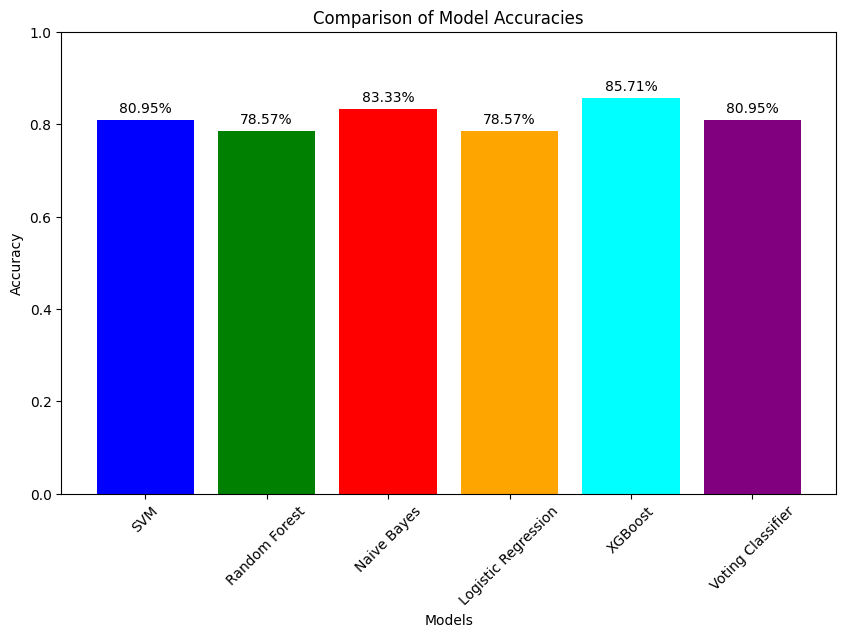

In [66]:
# Model names and their corresponding accuracies
models = ['SVM', 'Random Forest', 'Naive Bayes', 'Logistic Regression', 'XGBoost', 'Voting Classifier']
accuracies = [svm_accuracy, rf_accuracy, nb_accuracy, lr_accuracy, xgb_accuracy, voting_accuracy]

# Plotting the accuracies
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['blue', 'green', 'red', 'orange', 'cyan', 'purple'])
plt.ylim(0, 1)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.xticks(rotation=45)

# Adding percentage labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2%}', ha='center', va='bottom')

plt.show()